<a href="https://colab.research.google.com/github/chrispoole70/our-daily-stretch/blob/main/our_daily_stretch_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal for this agent is to be a stretching coach. The user could describe what's causing them discomfort and ask the coach for stretches to do. Then the coach could share a daily stretching plan with them and send a reminder to stretch.

---

**Here's an example ideal conversation:**
* Human: Hello, I'm feeling discomfort in my hips. I'm hoping you can help me create a stretching routine to alleviate some of this pain and improve my flexibility.
* AI: Hello, of course I can help you with that! I know a lot of good hip stretches that you can try. First, I'd like to know how much time you'd like to allot for stretching. Is five minutes ok?
* Human: Sure, five minutes sounds good.
* AI: Ok. Here are five hip stretches you could do for one minute each:
   1. _Stretch 1_
   2. _Stretch 2_
   3. _Stretch 3_
   4. _Stretch 4_
   5. _Stretch 5_

  How does this stretch plan look?
* Human: I think it looks good, let me give it a try.
* AI: Sure thing! Would you like me to send you a reminder to stretch?
* Human: Yeah, that would be helpful.
* AI: Great, I will send this stretch plan to you as a reminder. Would you like me to send it as a text message to your phone?
* Human: Yeah, that works.
* AI: Great, and how often would you like to stretch? I can send you a reminder everyday, for example.
* Human: Stretching everyday would be a good goal for me. Sure, you can send me a reminder everyday before I go to bed, around 9PM.
* AI: Absolutely! I will send this stretch plan to you tonight around 9PM via text message. Then I will send subsequent reminders everyday at 9PM. Good luck with the stretching and please let me know how it goes! I'm here to help if you want to revise your plan.
* Human: Thanks! I'll do the stretches and check in with you later.

---

**Here's a short conversation to get started with:**
* Human: Can you create a stretching routine for me? I'd like to focus on hip stretches to improve my flexibility. The plan should have five stretches that I can do for one minute each.
* AI: No problem! Here are five hip stretches you can do for one minute each:
   1. _Stretch 1_
   2. _Stretch 2_
   3. _Stretch 3_
   4. _Stretch 4_
   5. _Stretch 5_


In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [29]:
import os

from google.colab import userdata
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = userdata.get(var)

_set_env("OPENAI_API_KEY")

# Short Conversation

First, let's reverse engineer the application by starting with the short human conversation...

In [4]:
messages = [HumanMessage(content="""
Can you create a stretching routine for me? I'd like to focus on stretches to improve my flexibility.
The plan should have five stretches that I can do for one minute each.
""")]

Next, let's instantiate our LLM...

In [7]:
llm = ChatOpenAI(model="gpt-4o-mini")

Based on the short human message, we know that there will need to be a tool call to get the list of stretches...

In [8]:
from typing import List

def get_stretches() -> List[str]:
  ''' Returns a list of stretches
  '''
  return [
      'Archer Pose',
      'Four Corner Stretch',
      'Revolved Paying Homage',
      'Reverse Prayer',
      'Root Lock'
      ]

tools = [get_stretches]

In [9]:
llm_bound_to_tools = llm.bind_tools(tools=tools)

Then let's write down a system message with instructions for the LLM...

In [12]:
system_message = """
You are a stretch coach tasked with generating stretch plans. If a user asks for
stretches, only use the stretches returned from the tool called get_stretches.
"""

prompt_template = ChatPromptTemplate.from_messages(
    [
        ('system', system_message),
        MessagesPlaceholder(variable_name='messages')
    ]
)

# TODO: Trim the messages
def stretch_coach(state: MessagesState):
  prompt = prompt_template.invoke(input=state)
  response = llm_bound_to_tools.invoke(input=prompt)
  return {'messages': [response]}

In order to invoke the message, we need to:
1. Build the graph
2. Add nodes to the graph
3. Connect the nodes via edges
4. Preserve the conversation history in memory

In [14]:
# 1. Build the graph
graph_builder = StateGraph(MessagesState)

# 2. Add nodes to the graph
graph_builder.add_node('stretch_coach', stretch_coach)
graph_builder.add_node('tools', ToolNode(tools))

# 3. Connect the nodes via edges
graph_builder.add_edge(start_key=START, end_key='stretch_coach')
graph_builder.add_conditional_edges(source='stretch_coach', path=tools_condition)
graph_builder.add_edge(start_key='tools', end_key='stretch_coach')

# 4. Preserve the conversation history in memory
memory = MemorySaver()

# Lastly, compile the graph so that it can be invoked
runnable_graph = graph_builder.compile(checkpointer=memory)

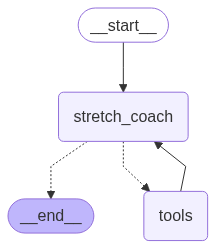

In [15]:
runnable_graph

In [17]:
config = {'configurable': {'thread_id': 'abc123'}}

In [20]:
for step in runnable_graph.stream(
    input={'messages': messages},
    config=config,
    stream_mode='values'
):
  step['messages'][-1].pretty_print()

================================ Human Message =================================


Can you create a stretching routine for me? I'd like to focus on stretches to improve my flexibility.
The plan should have five stretches that I can do for one minute each.

================================== Ai Message ==================================
Tool Calls:
  get_stretches (call_ipPXyv59zFDjTy8X49bOYnnC)
 Call ID: call_ipPXyv59zFDjTy8X49bOYnnC
  Args:
================================= Tool Message =================================
Name: get_stretches

["Archer Pose", "Four Corner Stretch", "Revolved Paying Homage", "Reverse Prayer", "Root Lock"]
================================== Ai Message ==================================

Here's a stretching routine to improve your flexibility, featuring five stretches you can hold for one minute each:

1. **Archer Pose** - This stretch will help open up your shoulders and improve your flexibility in the chest and arms.
  
2. **Four Corner Stretch** - This s

TODO:
* I'm not sure we want the LLM to generate instructions for each stretch in real-time. I should probably write instructions for each stretch when I record it. Or maybe I could have an LLM watch the video and generate instructions? It might be something to keep for now but improve later by adding vetted instructions.
* In order for the longer ideal conversation to be able to be had, I need to:
   1. Update the `get_stretches` tool to return stretches that are tagged with the body part the user wants to stretch.
   2. Add a tool (or another agent) for scheduling a reminder.
   3. Should the agent be given goals? Such as, goal 1 is figure out what types of stretches, goal 2 is to figure how many stretches, goal 3 is to figure out how long each stretch should be, etc.


# Longer Conversation

In [21]:
messages = [HumanMessage(content="""Hello, I'm feeling discomfort in my hips.
I'm hoping you can help me create a stretching routine to alleviate some of this
pain and improve my flexibility.
""")]

In [37]:
# System message
system_message = """
You are a stretch coach tasked with generating stretch plans. Here are your specific instructions:

* If a user asks for stretches, only use the stretches returned from the tool called get_stretches.
* When generating a stretch plan, include the stretch names but not descriptions of how to do the stretches.
* You have these goals to achieve in a conversation:
   1. Ask how long they would like to stretch for. 5 minutes is the default length of time.
   2. Ask how often they would like to stretch for. Daily is the default cadence.
   3. Generate a stretch plan that adheres to the user's time limit and cadence.


Below is an example of a conversation a user can have with you:

Human: Hello, I'm feeling discomfort in my hips. I'm hoping you can help me create a stretching routine to alleviate some of this pain and improve my flexibility.

AI: Hello, of course I can help you with that! I know a lot of good hip stretches that you can try. First, I'd like to know how much time you'd like to allot for stretching. Is five minutes ok?

Human: Sure, five minutes sounds good.

AI: Ok. Here are five hip stretches you could do for one minute each:
   * Stretch 1
   * Stretch 2
   * Stretch 3
   * Stretch 4
   * Stretch 5
How does this stretch plan look?

Human: Thanks, I think it looks good.

AI: Great, and how often would you like to stretch? Once a day?

Human: Stretching everyday would be a good goal for me. Let me try out these stretches later today.

AI: Sounds good, I hope it goes well!
"""

prompt_template = ChatPromptTemplate.from_messages(
    [
        ('system', system_message),
        MessagesPlaceholder(variable_name='messages')
    ]
)

# TODO: Trim the messages
def stretch_coach(state: MessagesState):
  prompt = prompt_template.invoke(input=state)
  response = llm_bound_to_tools.invoke(input=prompt)
  return {'messages': [response]}

In [38]:
# 1. Build the graph
graph_builder = StateGraph(MessagesState)

# 2. Add nodes to the graph
graph_builder.add_node('stretch_coach', stretch_coach)
graph_builder.add_node('tools', ToolNode(tools))

# 3. Connect the nodes via edges
graph_builder.add_edge(start_key=START, end_key='stretch_coach')
graph_builder.add_conditional_edges(source='stretch_coach', path=tools_condition)
graph_builder.add_edge(start_key='tools', end_key='stretch_coach')

# 4. Preserve the conversation history in memory
memory = MemorySaver()

# Lastly, compile the graph so that it can be invoked
runnable_graph = graph_builder.compile(checkpointer=memory)

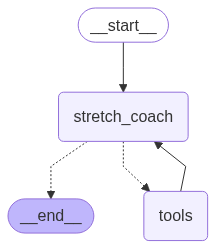

In [39]:
runnable_graph

In [40]:
runnable_graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': 'abc123'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [41]:
messages

[HumanMessage(content="Hello, I'm feeling discomfort in my hips. \nI'm hoping you can help me create a stretching routine to alleviate some of this \npain and improve my flexibility.\n", additional_kwargs={}, response_metadata={}, id='05b20552-a4ef-4d9d-bd5a-8262ab634d0c')]

In [42]:
for step in runnable_graph.stream(
    input={'messages': messages},
    config=config,
    stream_mode='values'
):
  step['messages'][-1].pretty_print()

================================ Human Message =================================

Hello, I'm feeling discomfort in my hips. 
I'm hoping you can help me create a stretching routine to alleviate some of this 
pain and improve my flexibility.

================================== Ai Message ==================================

Hello, of course I can help you with that! I know a lot of good hip stretches that you can try. First, I'd like to know how much time you'd like to allot for stretching. Is five minutes ok?


In [43]:
new_user_message = 'Sure, five minutes is ok.'

for step in runnable_graph.stream(
    input={'messages': messages + [HumanMessage(content=new_user_message)]},
    config=config,
    stream_mode='values'
):
  step['messages'][-1].pretty_print()

================================ Human Message =================================

Sure, five minutes is ok.
================================== Ai Message ==================================
Tool Calls:
  get_stretches (call_okmJIebNedWAkH6AKCXDv16n)
 Call ID: call_okmJIebNedWAkH6AKCXDv16n
  Args:
================================= Tool Message =================================
Name: get_stretches

["Archer Pose", "Four Corner Stretch", "Revolved Paying Homage", "Reverse Prayer", "Root Lock"]
================================== Ai Message ==================================

Great! Here are five hip stretches you could do for one minute each:

* Archer Pose
* Four Corner Stretch
* Revolved Paying Homage
* Reverse Prayer
* Root Lock

How does this stretch plan look?


In [44]:
new_user_message = 'Looks good to me!'

for step in runnable_graph.stream(
    input={'messages': messages + [HumanMessage(content=new_user_message)]},
    config=config,
    stream_mode='values'
):
  step['messages'][-1].pretty_print()

================================ Human Message =================================

Looks good to me!
================================== Ai Message ==================================

Awesome! Now, how often would you like to stretch? Would stretching every day be a good goal for you?


In [45]:
new_user_message = 'Yes, stretching everyday would be a good goal for me. I will start today!'

for step in runnable_graph.stream(
    input={'messages': messages + [HumanMessage(content=new_user_message)]},
    config=config,
    stream_mode='values'
):
  step['messages'][-1].pretty_print()

================================ Human Message =================================

Yes, stretching everyday would be a good goal for me. I will start today!
================================== Ai Message ==================================

Sounds great! I'm glad you're starting today. Enjoy your stretches, and I hope they help with your hip discomfort! If you need any more assistance in the future, feel free to ask.


TODO: Update the state schema to capture the:
* Stretch duration
* Stretch cadence
* Stretch plan